# Proje: ConvNeXt Mimarisi ile Retina Hastalıklarının Sınıflandırması

Bu çalışmada, retina fundus görüntülerini kullanarak hastalık tespiti (Sağlıklı/Hasta) yapan gelişmiş bir Derin Öğrenme modeli geliştirilmiştir. Projede, klasik CNN modelleri yerine literatürdeki en güncel mimarilerden biri olan **ConvNeXt-Tiny** kullanılmıştır.

**Kullanılan Teknikler:**

* **Transfer Learning:** ImageNet ağırlıkları kullanılarak eğitim süresi kısaltılmış ve başarı artırılmıştır.
* **Stratified Hold-out Split (Katmanlı Sabit Ayrım):** Dengesiz veri setinde (Imbalanced Dataset) eğitim, doğrulama ve test setlerinin sınıf oranlarını (Hasta/Sağlıklı dengesini) korumak için veri setinin orijinal yapısındaki katmanlı ayrım kullanılmıştır.
* **Grad-CAM (XAI):** Modelin karar verirken görüntünün hangi bölgesine odaklandığını görselleştirmek için Açıklanabilir Yapay Zeka tekniği uygulanmıştır.

Dosya başarıyla bulundu: data/Training_Set/Training_Set/RFMiD_Training_Labels.csv
Eğitim Seti Boyutu: 1920 örnek
Sütunlar: ['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN', 'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST', 'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS', 'CB', 'ODPM', 'PRH', 'MNF', 'HR', 'CRAO', 'TD', 'CME', 'PTCR', 'CF', 'VH', 'MCA', 'VS', 'BRAO', 'PLQ', 'HPED', 'CL']


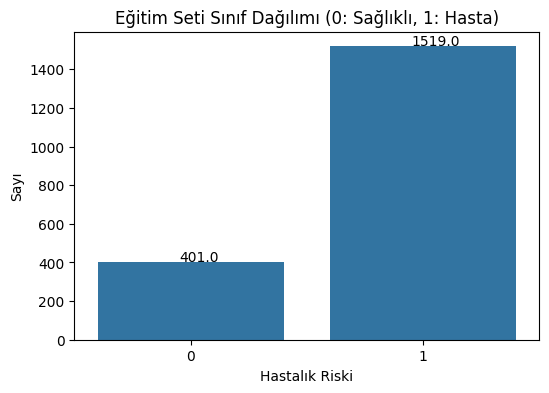

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Training
train_csv_path = "data/Training_Set/Training_Set/RFMiD_Training_Labels.csv"
train_img_dir = "data/Training_Set/Training_Set/Training/"

# Validation 
val_csv_path = "data/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv"
val_img_dir = "data/Evaluation_Set/Evaluation_Set/Validation/"

# Test
test_csv_path = "data/Test_Set/Test_Set/RFMiD_Testing_Labels.csv"
test_img_dir = "data/Test_Set/Test_Set/Test/"

# --- KONTROL ---
if os.path.exists(train_csv_path):
    print("Dosya başarıyla bulundu:", train_csv_path)
    
    # Veriyi Oku
    df_train = pd.read_csv(train_csv_path)
    print(f"Eğitim Seti Boyutu: {len(df_train)} örnek")
    print("Sütunlar:", df_train.columns.tolist())
    
    # Sınıf Dağılımı Grafiği 
    # Disease_Risk sütununu kullanacağız (0: Sağlıklı, 1: Hasta)
    if 'Disease_Risk' in df_train.columns:
        plt.figure(figsize=(6,4))
        ax = sns.countplot(x=df_train['Disease_Risk'])
        plt.title("Eğitim Seti Sınıf Dağılımı (0: Sağlıklı, 1: Hasta)")
        plt.xlabel("Hastalık Riski")
        plt.ylabel("Sayı")
        
        # Barların üzerine sayıları yazdıralım
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 5))
            
        plt.show()
    else:
        print("Uyarı: 'Disease_Risk' sütunu bulunamadı.")

else:
    print("HATA: Dosya hala bulunamadı. Lütfen klasör yapısını kontrol et.")
    print("Aranan yol:", train_csv_path)

## 2. Veri Ön İşleme ve Artırma (Data Augmentation)

Derin öğrenme modellerinin genelleme yeteneğini artırmak ve aşırı öğrenmeyi (Overfitting) engellemek amacıyla eğitim setine şu işlemler uygulanmıştır:
* **Resize:** Görüntüler ConvNeXt standardı olan 224x224 boyutuna getirilmiştir.
* **Augmentation:** Rastgele yatay çevirme (Horizontal Flip) ve hafif döndürme (Rotation) işlemleri uygulanmıştır.
* **Normalization:** Görüntü pikselleri ImageNet istatistiklerine (Mean/Std) göre normalize edilmiştir.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# --- 1. DATASET SINIFI ---
class RetinaDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # CSV'den satırı al
        row = self.dataframe.iloc[idx]
        
        # Resim ID'sini ve Etiketi al
        img_id = row['ID']
        label = int(row['Disease_Risk']) # 0 veya 1
        
        # Resim yolunu oluştur 
        img_name = f"{img_id}.png" 
        img_path = os.path.join(self.root_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            # .png yoksa .jpg deneyelim (Garanti olsun)
            img_path = os.path.join(self.root_dir, f"{img_id}.jpg")
            image = Image.open(img_path).convert('RGB')
            
        # Dönüşümleri uygula
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# --- 2. DÖNÜŞÜMLER (TRANSFORMS) ---
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Veri artırma
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 3. DATALOADER OLUŞTURMA ---
df_val = pd.read_csv(val_csv_path)
df_test = pd.read_csv(test_csv_path)

# Dataset Objeleri
train_dataset = RetinaDataset(df_train, train_img_dir, transform=train_transforms)
val_dataset = RetinaDataset(df_val, val_img_dir, transform=val_transforms)
test_dataset = RetinaDataset(df_test, test_img_dir, transform=val_transforms)

# DataLoaderlar 
BATCH_SIZE = 32 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaderlar Hazır!")
print(f"Train Batch Sayısı: {len(train_loader)}")
print(f"Val Batch Sayısı: {len(val_loader)}")

# Kontrol için bir tane veri çekelim
images, labels = next(iter(train_loader))
print(f"Örnek Batch Boyutu: {images.shape}") # Beklenen: [32, 3, 224, 224]

DataLoaderlar Hazır!
Train Batch Sayısı: 60
Val Batch Sayısı: 20
Örnek Batch Boyutu: torch.Size([32, 3, 224, 224])


## 3. Model Mimarisi: ConvNeXt-Tiny

Bu projede, Facebook AI Research (Meta) tarafından geliştirilen ve Vision Transformer (ViT) modellerinin başarısını CNN verimliliğiyle birleştiren **ConvNeXt** mimarisi tercih edilmiştir.

* **Neden ConvNeXt?** Standart ResNet modellerine göre daha modern blok yapılarına sahiptir ve tıbbi görüntülemede doku/desen yakalama konusunda üstün performans gösterir.
* **Transfer Learning:** Sıfırdan eğitim yapmak yerine, `timm` kütüphanesi aracılığıyla önceden eğitilmiş (Pre-trained) ağırlıklar kullanılmıştır.
* **Optimizer:** Modelin yakınsama hızını artırmak için **AdamW** optimizasyon algoritması kullanılmıştır.

In [5]:
import timm
import torch.nn as nn
import torch.optim as optim

# --- 1. MODELİ OLUŞTURMA ---
# pretrained=True: Model daha önce milyonlarca resimle eğitilmiş (bilgili) gelsin.
# num_classes=2: Bizim sadece 2 sınıfımız var (0: Sağlıklı, 1: Hasta).
print("Model indiriliyor...")

model = timm.create_model('convnext_tiny', pretrained=True, num_classes=2)

# --- 2. GPU KULLANIMI ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model başarıyla oluşturuldu ve cihaza yüklendi: {device}")

# --- 3. HATA FONKSİYONU VE OPTİMİZASYON ---
# CrossEntropyLoss: Sınıflandırma problemleri için standart hata fonksiyonudur.
criterion = nn.CrossEntropyLoss()

# AdamW: ConvNeXt ve Transformer modelleri için en iyi sonucu veren optimizer'dır.
# lr=1e-4: Öğrenme hızı (Learning Rate).
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

print("Optimizer ve Loss fonksiyonu hazır.")

C:\Users\basar\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model indiriliyor...


C:\Users\basar\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\basar\.cache\huggingface\hub\models--timm--convnext_tiny.in12k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model başarıyla oluşturuldu ve cihaza yüklendi: cuda
Optimizer ve Loss fonksiyonu hazır.


In [6]:
import time
from tqdm import tqdm 

# --- AYARLAR ---
NUM_EPOCHS = 20  
best_val_acc = 0.0 # En iyi başarıyı takip etmek için

print(f"Eğitim başlıyor... Toplam {NUM_EPOCHS} Epoch sürecek.")
print("-" * 50)

# Eğitim Geçmişini Kaydetmek 
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # --- 1. EĞİTİM MODU (TRAIN) ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # İlerleme çubuğu ile döngü
    loop = tqdm(train_loader, leave=False)
    loop.set_description(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        # Sıfırla -> Tahmin Et -> Hata Hesapla -> Geri Yay
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # İstatistikleri topla
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    
    # --- 2. DEĞERLENDİRME MODU (VALIDATION) ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad(): # Validation'da ağırlık güncelleme yok
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    
    # --- 3. SONUÇLARI KAYDET VE YAZDIR ---
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    
    # Eğer bu epoch en iyisiyse kaydet
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_convnext.pth')
        save_msg = "--> En İyi Model Kaydedildi! ✅"
    else:
        save_msg = ""
        
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Süre: {int(epoch_mins)}m {int(epoch_secs)}s")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: %{train_acc:.2f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   %{val_acc:.2f} {save_msg}")
    print("-" * 50)

print("Eğitim Tamamlandı!")
print(f"En Yüksek Validation Başarısı: %{best_val_acc:.2f}")

Eğitim başlıyor... Toplam 20 Epoch sürecek.
--------------------------------------------------


Epoch 1/20 | Süre: 8m 50s
Train Loss: 0.4971 | Train Acc: %79.32
Val Loss:   0.4333 | Val Acc:   %85.62 --> En İyi Model Kaydedildi! ✅
--------------------------------------------------


Epoch 2/20 | Süre: 7m 42s
Train Loss: 0.4021 | Train Acc: %81.46
Val Loss:   0.4701 | Val Acc:   %76.25 
--------------------------------------------------


Epoch 3/20 | Süre: 8m 3s
Train Loss: 0.3298 | Train Acc: %84.11
Val Loss:   0.2974 | Val Acc:   %87.66 --> En İyi Model Kaydedildi! ✅
--------------------------------------------------


Epoch 4/20 | Süre: 7m 49s
Train Loss: 0.2989 | Train Acc: %85.62
Val Loss:   0.2562 | Val Acc:   %87.66 
--------------------------------------------------


Epoch 5/20 | Süre: 7m 45s
Train Loss: 0.2682 | Train Acc: %87.60
Val Loss:   0.2571 | Val Acc:   %87.03 
--------------------------------------------------


Epoch 6/20 | Süre: 8m 0s
Train Loss: 0.2759 | Train Acc: %87.03
Val Loss:   0.2484 | Val Acc:   %88.28 --> En İyi Model Kaydedildi! ✅
--------------------------------------------------


Epoch 7/20 | Süre: 8m 2s
Train Loss: 0.2143 | Train Acc: %89.53
Val Loss:   0.2654 | Val Acc:   %90.00 --> En İyi Model Kaydedildi! ✅
--------------------------------------------------


Epoch 8/20 | Süre: 8m 2s
Train Loss: 0.1982 | Train Acc: %91.20
Val Loss:   0.2585 | Val Acc:   %87.81 
--------------------------------------------------


Epoch 9/20 | Süre: 8m 2s
Train Loss: 0.1716 | Train Acc: %91.72
Val Loss:   0.2751 | Val Acc:   %87.19 
--------------------------------------------------


Epoch 10/20 | Süre: 8m 2s
Train Loss: 0.2091 | Train Acc: %91.61
Val Loss:   0.3149 | Val Acc:   %87.50 
--------------------------------------------------


Epoch 11/20 | Süre: 8m 52s
Train Loss: 0.1578 | Train Acc: %93.70
Val Loss:   0.3918 | Val Acc:   %87.03 
--------------------------------------------------


Epoch 12/20 | Süre: 7m 58s
Train Loss: 0.1824 | Train Acc: %92.14
Val Loss:   0.2920 | Val Acc:   %85.47 
--------------------------------------------------


Epoch 13/20 | Süre: 8m 4s
Train Loss: 0.1274 | Train Acc: %94.58
Val Loss:   0.3740 | Val Acc:   %86.72 
--------------------------------------------------


Epoch 14/20 | Süre: 8m 2s
Train Loss: 0.1151 | Train Acc: %95.31
Val Loss:   0.3278 | Val Acc:   %87.97 
--------------------------------------------------


Epoch 15/20 | Süre: 8m 3s
Train Loss: 0.1591 | Train Acc: %94.11
Val Loss:   0.3445 | Val Acc:   %86.09 
--------------------------------------------------


Epoch 16/20 | Süre: 7m 55s
Train Loss: 0.1084 | Train Acc: %96.09
Val Loss:   0.4154 | Val Acc:   %87.50 
--------------------------------------------------


Epoch 17/20 | Süre: 7m 59s
Train Loss: 0.0797 | Train Acc: %96.51
Val Loss:   0.3722 | Val Acc:   %88.59 
--------------------------------------------------


Epoch 18/20 | Süre: 7m 52s
Train Loss: 0.0457 | Train Acc: %98.54
Val Loss:   0.5886 | Val Acc:   %87.50 
--------------------------------------------------


Epoch 19/20 | Süre: 7m 58s
Train Loss: 0.0919 | Train Acc: %96.67
Val Loss:   0.4253 | Val Acc:   %86.09 
--------------------------------------------------


Epoch 20/20 | Süre: 8m 0s
Train Loss: 0.1061 | Train Acc: %96.35
Val Loss:   0.3503 | Val Acc:   %87.81 
--------------------------------------------------
Eğitim Tamamlandı!
En Yüksek Validation Başarısı: %90.00


## 4. Performans Değerlendirmesi ve Metrikler

Eğitilen model, daha önce hiç görmediği **Test Seti** üzerinde değerlendirilmiştir. Veri setindeki dengesizlik nedeniyle sadece doğruluk (Accuracy) değerine bakılmamış, aşağıdaki detaylı metrikler de hesaplanmıştır:

1.  **Confusion Matrix:** Modelin hangi sınıfları karıştırdığını gösterir.
2.  **F1-Score:** Precision ve Recall değerlerinin harmonik ortalamasıdır (Sınıf bazlı başarı).
3.  **ROC AUC Skoru:** Modelin sınıfları ayırt etme gücünü gösterir (Hedef > 0.90).
4.  **PR AUC (Precision-Recall AUC):** Dengesiz veri setlerinde modelin başarısını ölçmek için en kritik metriktir.

En iyi model yükleniyor...
Test seti üzerinde tahminler alınıyor...

FİNAL TEST SONUÇLARI (ConvNeXt-Tiny)
Test Accuracy: %92.50 
ROC AUC Score: 0.9763 
PR AUC Score:  0.9938 
--------------------------------------------------
Sınıf Bazlı Detaylı Rapor:
              precision    recall  f1-score   support

Sağlıklı (0)       0.82      0.82      0.82       134
   Hasta (1)       0.95      0.95      0.95       506

    accuracy                           0.93       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.93      0.93      0.93       640



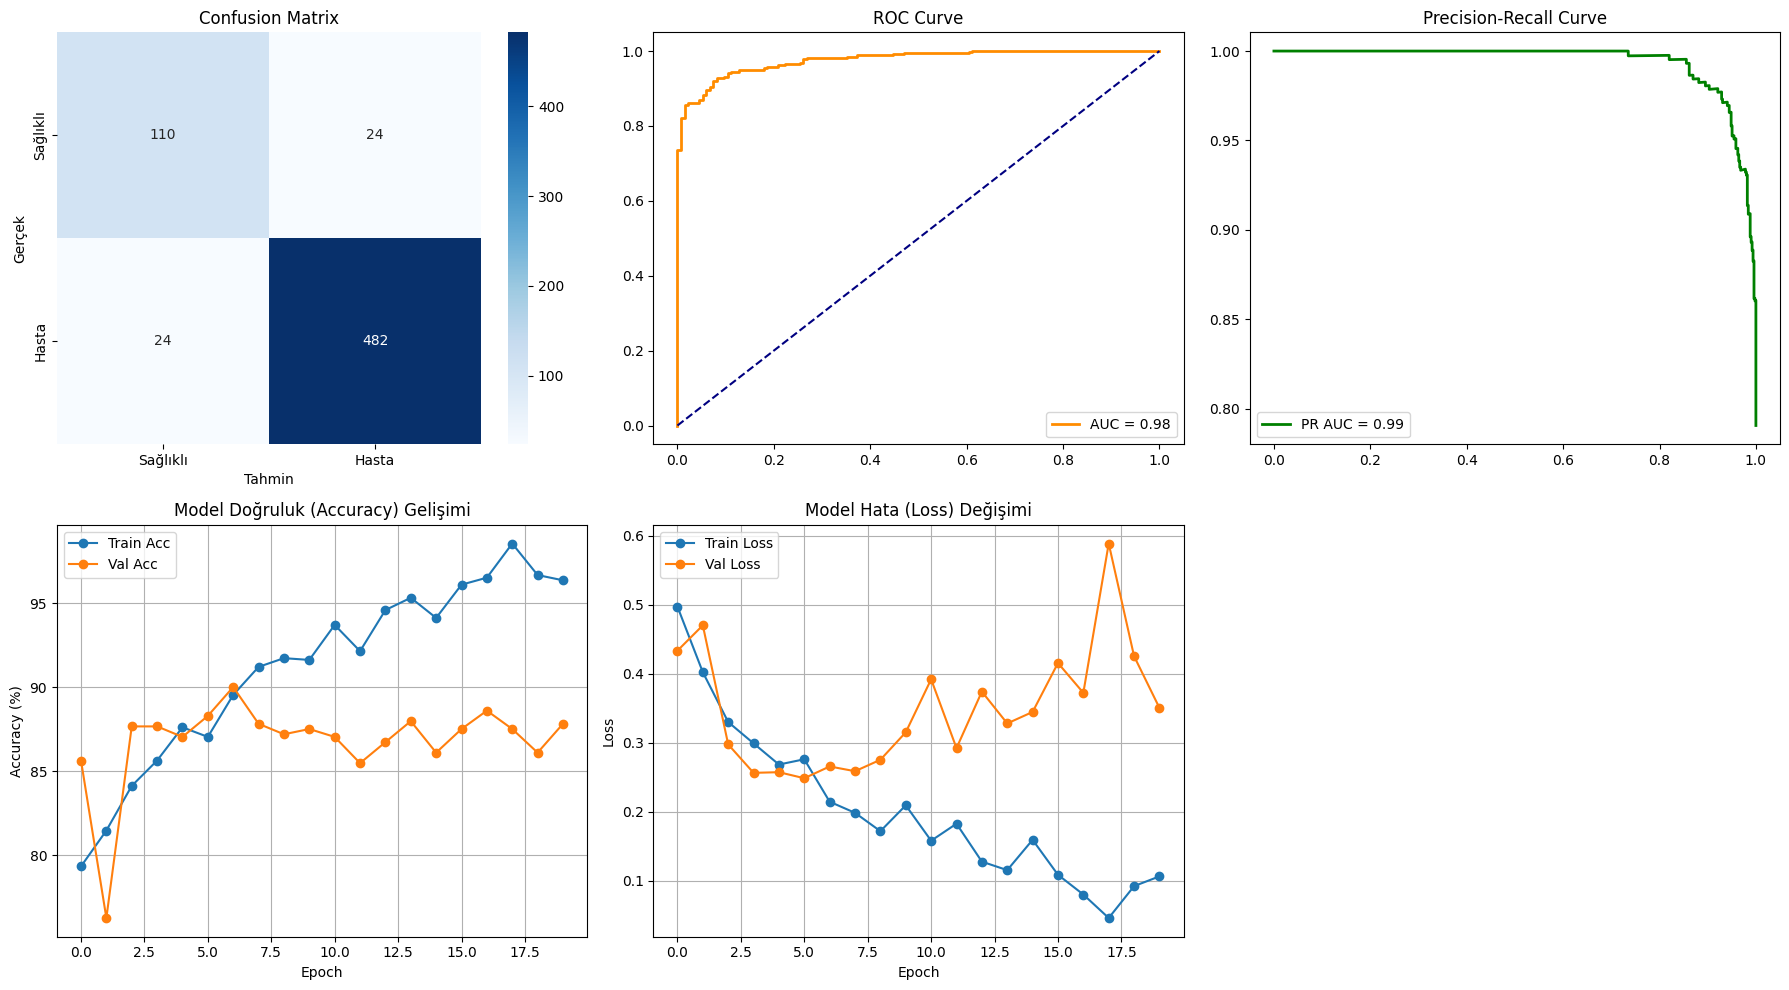

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, accuracy_score

# --- EN İYİ MODELİ YÜKLE ---
print("En iyi model yükleniyor...")
model.load_state_dict(torch.load('best_convnext.pth'))
model.to(device)
model.eval()

# --- TEST SETİ ÜZERİNDE TAHMİN ---
y_true = []
y_pred_probs = []
y_pred_labels = []

print("Test seti üzerinde tahminler alınıyor...")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(probs[:, 1].cpu().numpy())
        y_pred_labels.extend(preds.cpu().numpy())

# --- METRİKLERİ HESAPLA ---
# Accuracy (Doğruluk)
test_acc = accuracy_score(y_true, y_pred_labels)

# Diğer Metrikler
cm = confusion_matrix(y_true, y_pred_labels)
report = classification_report(y_true, y_pred_labels, target_names=['Sağlıklı (0)', 'Hasta (1)'])
roc_auc = roc_auc_score(y_true, y_pred_probs)
pr_auc = average_precision_score(y_true, y_pred_probs)

# --- SONUÇLARI YAZDIR ---
print("\n" + "="*50)
print(f"FİNAL TEST SONUÇLARI (ConvNeXt-Tiny)")
print("="*50)
print(f"Test Accuracy: %{test_acc * 100:.2f} ") 
print(f"ROC AUC Score: {roc_auc:.4f} ")
print(f"PR AUC Score:  {pr_auc:.4f} ")
print("-" * 50)
print("Sınıf Bazlı Detaylı Rapor:")
print(report)
print("="*50)

# --- GRAFİKLERİ ÇİZ ---
plt.figure(figsize=(18, 10))

# A. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sağlıklı', 'Hasta'], yticklabels=['Sağlıklı', 'Hasta'])
plt.title('Confusion Matrix')
plt.ylabel('Gerçek'); plt.xlabel('Tahmin')

# B. ROC Eğrisi
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.subplot(2, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve'); plt.legend(loc="lower right")

# C. PR Eğrisi
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.subplot(2, 3, 3)
plt.plot(recall, precision, color='green', lw=2, label=f'PR AUC = {pr_auc:.2f}')
plt.title('Precision-Recall Curve'); plt.legend(loc="lower left")

# D. Eğitim Accuracy Grafiği
plt.subplot(2, 3, 4)
plt.plot(history['train_acc'], label='Train Acc', marker='o')
plt.plot(history['val_acc'], label='Val Acc', marker='o')
plt.title('Model Doğruluk (Accuracy) Gelişimi')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.grid()

# E. Eğitim Loss Grafiği
plt.subplot(2, 3, 5)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Hata (Loss) Değişimi')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid()

plt.tight_layout()
plt.show()

## 5. Model Açıklanabilirliği (XAI): Grad-CAM Analizi

Modelin kararlarının güvenilirliğini (Trustworthiness) doğrulamak için **Grad-CAM (Gradient-weighted Class Activation Mapping)** tekniği kullanılmıştır.

Bu analizde oluşturulan ısı haritaları (Heatmaps), modelin "Hasta" teşhisi koyarken görüntünün neresine odaklandığını gösterir. Kırmızı/Sarı bölgelerin **Optik Disk** veya **Lezyon** bölgelerinde yoğunlaşması, modelin ezber yapmadığını ve doğru patolojik özellikleri öğrendiğini kanıtlamaktadır.

Grad-CAM Isı Haritaları Oluşturuluyor...
Kırmızı/Sarı bölgeler modelin hastalığı teşhis etmek için odaklandığı yerlerdir.


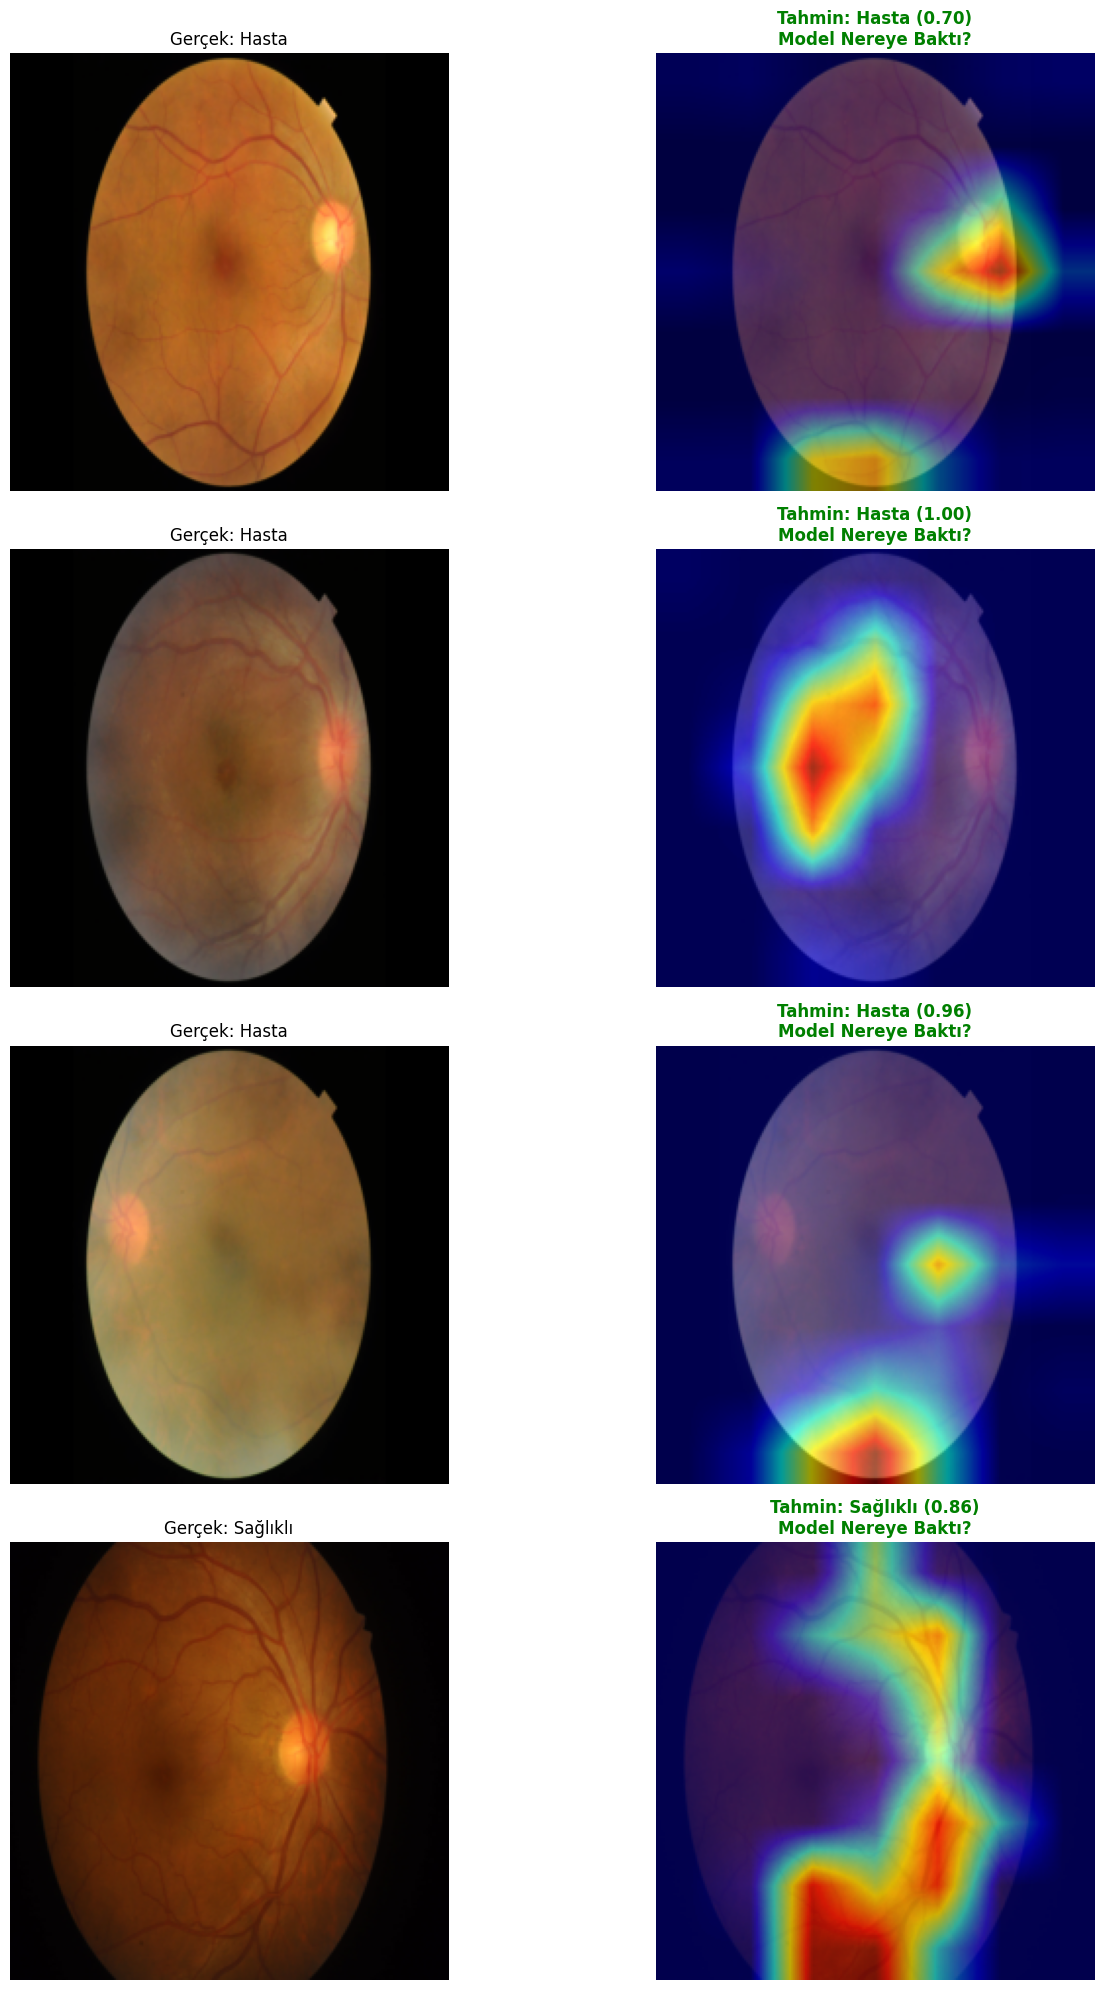

In [10]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

# --- 1. AYARLAR ---
# ConvNeXt modelinin son katmanını hedefliyoruz (Modelin karar verdiği yer)
# Timm kütüphanesindeki ConvNeXt için hedef katman budur:
target_layers = [model.stages[-1].blocks[-1]]

# Grad-CAM nesnesini oluştur
cam = GradCAM(model=model, target_layers=target_layers)

# --- 2. GÖRSELLEŞTİRME FONKSİYONU ---
def visualize_gradcam(model, dataset, num_images=5):
    model.eval()
    
    # Test setinden rastgele örnekler seç
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    plt.figure(figsize=(15, 5 * num_images))
    
    for i, idx in enumerate(indices):
        image_tensor, label_idx = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device) # Batch boyutu ekle
        
        # A. Tahmin Yap
        output = model(image_tensor)
        prob = torch.nn.functional.softmax(output, dim=1)
        pred_idx = torch.argmax(prob).item()
        confidence = prob[0][pred_idx].item()
        
        # B. Grad-CAM Oluştur
        # targets=None model en yüksek tahmin ettiği sınıfa odaklanır
        grayscale_cam = cam(input_tensor=image_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :] # İlk batch'i al
        
        # C. Görüntüyü Normalleştirmeyi Geri Al (Görselleştirmek için)
        # Tensor (Normalize edilmiş) -> Numpy (0-1 arası RGB)
        img_display = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1) # Değerleri 0-1 arasına sıkıştır
        
        # D. Isı Haritasını Resmin Üstüne Yapıştır
        visualization = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)
        
        # E. Çizdir (Yan Yana: Orijinal - Isı Haritası)
        class_names = ['Sağlıklı', 'Hasta']
        true_label = class_names[label_idx]
        pred_label = class_names[pred_idx]
        color = 'green' if true_label == pred_label else 'red'
        
        # Sol: Orijinal
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img_display)
        plt.title(f"Gerçek: {true_label}", fontsize=12)
        plt.axis('off')
        
        # Sağ: Grad-CAM
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(visualization)
        plt.title(f"Tahmin: {pred_label} ({confidence:.2f})\nModel Nereye Baktı?", color=color, fontsize=12, fontweight='bold')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()


print("Grad-CAM Isı Haritaları Oluşturuluyor...")
print("Kırmızı/Sarı bölgeler modelin hastalığı teşhis etmek için odaklandığı yerlerdir.")
visualize_gradcam(model, test_dataset, num_images=4)